In [1]:
# This is to plot
import os
os.chdir('/hpcnfs/scratch/EO/selectionIta_HSD3B1/')

In [2]:
# Load the modules
import numpy as np
import sys
import pandas as pd
import glob

from scipy.stats import uniform
from scipy.stats import randint
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import xlsxwriter

In [3]:
# This function clean the output of scikit-all

def select_postiviePBS(pathfiles):
    
    read_files = glob.glob(pathfiles)
    
    # Empty list in which you will insert the df
    res_totchrom = []

    for f in read_files:
        df = pd.read_csv(f, sep= "\t")
        res_totchrom.append(df)
        
    # Concat all the df in one
    res_tot = pd.concat(res_totchrom, axis=0, ignore_index=True)
    # Only complete cases
    res_tot_drop = res_tot.dropna()
    # Only the positive selected
    is_pos_tab = res_tot_drop[res_tot_drop['PBS'] > 0]
    
    return(is_pos_tab)

In [4]:
# This function clean the output of scikit-all

def select_postivieTaj(pathfiles):
    
    read_files = glob.glob(pathfiles)
    
    # Empty list in which you will insert the df
    res_totchrom = []

    for f in read_files:
        df = pd.read_csv(f, sep= "\t")
        res_totchrom.append(df)
        
    # Concat all the df in one
    res_tot = pd.concat(res_totchrom, axis=0, ignore_index=True)
    # Only complete cases
    res_tot_drop = res_tot.dropna()
    # Only the positive selected
    is_pos_tab = res_tot_drop[res_tot_drop['TajD'] > 0]
    
    return(is_pos_tab)

In [5]:
pathfiles=["PBS_scikit_*TSICHB*YRIv2.txt",
           "PBS_scikit_*IBSCHB*YRIv2.txt"]

names_file= ['PBS_posSelec_TSICHBYRIallchromV2.txt',
            'PBS_posSelec_IBSCHBYRIallchromV2.txt']

df_4plot = []

for p in range(len(pathfiles)):

    t =select_postiviePBS(pathfiles[p])
    # Change again in pos and chro
    pos_chrom = t['pos'].str.split("_", n=1, expand= True)
    t['chromosome'] = pos_chrom[0].astype(float)
    t['position'] = pos_chrom[1].astype(float)

    tsave = t.drop(columns = ['Unnamed: 0'], axis=1)
    df_4plot.append(tsave)
    t.to_csv(names_file[p], sep="\t")


In [6]:
# save the Tajima

pathfiles="TajD*TSI*YRIv2.txt"

tajDf = select_postivieTaj(pathfiles)

# Change again in pos and chro
tajDf.chromosome = tajDf.chromosome.astype(float)
tajDf= tajDf.sort_values(by=['chromosome'])
tajDf = tajDf.drop(columns = ['Unnamed: 0'], axis=1)
tajDf.chromosome = tajDf.chromosome.astype(str)


In [7]:
# Define the limits 00.1%
PBS_top001perc1 = df_4plot[0].quantile(.9999, axis=0)['PBS']
PBS_top001perc2 = df_4plot[1].quantile(.9999, axis=0)['PBS']

In [8]:
# Save the table with the only SNPs positive selected and the region of interest of our SNP
dTSI = df_4plot[0]
dIBS = df_4plot[1]

dTSI2save_toperc = dTSI[dTSI['PBS']  > PBS_top001perc1]
dIBS2save_toperc = dIBS[dIBS['PBS']  > PBS_top001perc2]

dTSI2save_chr1 = dTSI[(dTSI['chromosome'] == 1) & 
          (dTSI['position']  >= 120049933) & 
          (dTSI['position']  <= 120057540)]

dIBS2save_chr1 = dIBS[(dIBS['chromosome'] == 1) & 
          (dIBS['position']  >= 120049933) & 
          (dIBS['position']  <= 120057540)]

writer1 = pd.ExcelWriter('pbs_tosing_chr1regV4.xlsx', engine= 'xlsxwriter')



dTSI2save_toperc.to_excel(writer1, sheet_name = 'TSI top %', index = False)
dIBS2save_toperc.to_excel(writer1, sheet_name = 'IBS top %', index = False)
    
dTSI2save_chr1.to_excel(writer1, sheet_name = 'TSI region of interest', index = False)

dIBS2save_chr1.to_excel(writer1, sheet_name = 'IBS region of interest', index = False)

tajDf.to_excel(writer1, sheet_name = 'TSI D Tajima og YRI', index = False)

wb = writer1.book
ws1 = writer1.sheets['TSI region of interest']
ws2 = writer1.sheets['IBS region of interest']
ws3 = writer1.sheets['TSI D Tajima og YRI']
# Define the format
f1 = wb.add_format({
                    'bg_color': 'b'})

ws1.conditional_format('B2:B22', {'type':     'cell',
                                        'criteria': '==',
                                        'value':    '"rs1047303"',
                                        'format':   f1})


ws2.conditional_format('B2:B22', {'type':     'cell',
                                        'criteria': '==',
                                        'value':    '"rs1047303"',
                                        'format':   f1})

ws3.conditional_format('A1:A500', {'type':     'cell',
                                        'criteria': '==',
                                        'value':    '"120017181_120157835"',
                                        'format':   f1})


writer1.save()

In [9]:
# Function to prepare the df of the plot
def sort_index_df(df):
    df= df.sort_values(by=['chromosome', 'position'])
    df.chromosome = df.chromosome.astype(str)
    df['ind'] = range(len(df))
#     df_grouped = df.groupby(('chromosome'))
    return(df)


In [10]:
# Sort, index and group

dfTSI_sort = sort_index_df(dTSI)

dfTSI_group = dfTSI_sort.groupby(('chromosome'), sort=False)


dfIBS_sort = sort_index_df(dIBS)

dfIBS_group = dfIBS_sort.groupby(('chromosome'), sort=False)

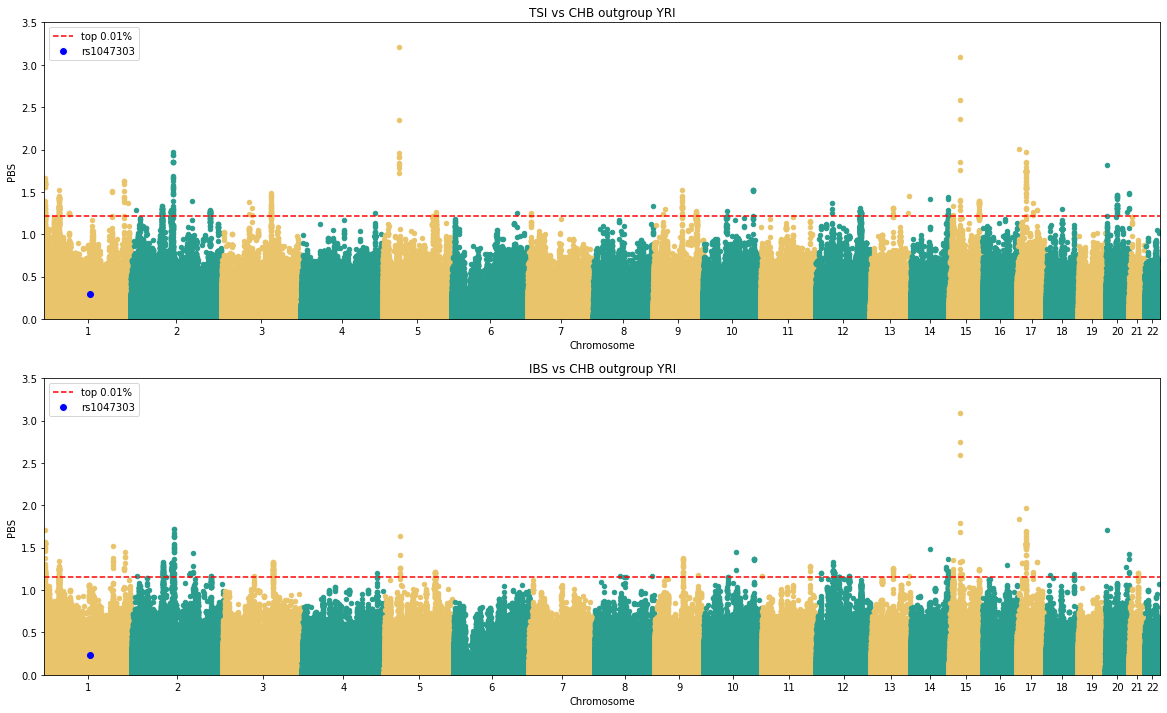

In [12]:
leg_el = [Line2D([0], [0], c= 'r' , linestyle = '--'),
    Line2D([0], [0], marker = 'o', c= 'w',
                markerfacecolor='b', markersize= 8) ]


fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

# First
ax1.set_title("TSI vs CHB outgroup YRI")    

# ax1 = fig.add_subplot(211)

ax1.axhline(y=PBS_top001perc1, color='r', linestyle='--')

colors = ['#e9c46a','#2a9d8f']

x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(dfTSI_group):
    group.plot(kind='scatter', x='ind', y='PBS',color=colors[num % len(colors)], ax=ax1)
    x_labels.append(int(float(name)))
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax1.set_xticks(x_labels_pos)
ax1.set_xticklabels(x_labels)
ax1.set_xlim([0, len(dfTSI_sort)])
ax1.set_ylim([0, 3.5])
ax1.set_xlabel('Chromosome')

ax1.legend(leg_el, ['top 0.01%','rs1047303'], loc="upper left")

ax1.scatter(dfTSI_sort['ind'][dfTSI_sort['rs']== 'rs1047303'], dfTSI_sort['PBS'][dfTSI_sort['rs']== 'rs1047303'], c= 'b')

# Second

ax2.set_title("IBS vs CHB outgroup YRI")

# ax2 = fig.add_subplot(212)

ax2.axhline(y=PBS_top001perc2, color='r', linestyle='--')

colors = ['#e9c46a','#2a9d8f']

x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(dfIBS_group):
    group.plot(kind='scatter', x='ind', y='PBS',color=colors[num % len(colors)], ax=ax2)
    x_labels.append(int(float(name)))
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax2.set_xticks(x_labels_pos)
ax2.set_xticklabels(x_labels)
ax2.set_xlim([0, len(dfIBS_sort)])
ax2.set_ylim([0, 3.5])
ax2.set_xlabel('Chromosome')

ax2.legend(leg_el, ['top 0.01%','rs1047303'], loc="upper left")

ax2.scatter(dfIBS_sort['ind'][dfIBS_sort['rs']== 'rs1047303'], dfIBS_sort['PBS'][dfIBS_sort['rs']== 'rs1047303'], c= 'b')

plt.savefig('ManatthanTSI_IBSV2.png', dpi=300)